In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import model_crommelin_seasonal
import feature_crommelin 
from importlib import reload
import sys 
import os
from os import mkdir, makedirs
from os.path import join,exists
from importlib import reload
import pickle
import helper2

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

Create directories to save results 

In [3]:
# Organize the directory of data and features to be read from the data. 
topic_dir = "/scratch/jf4241/crommelin"
filedict = dict({
    "data": dict({
        "ra": dict({
            "traj": dict({
                "dir": join(topic_dir, "reanalysis", "trajectory", "2022-07-27", "0"), # Directory with possibly many files
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "reanalysis", "features_all", "2022-07-27", "0"),
                "filename": "crom_feat_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "reanalysis", "features_tpt", "2022-07-27", "0",),
                "filename": "crom_feat_tpt.nc",
            }),
        }),
        "hc": dict({
            "traj": dict({
                "dir": join(topic_dir, "hindcast", "trajectory", "2022-07-27", "0"), # Directory with possibly multiple files
            }),
            "feat_all": dict({
                "dir": join(topic_dir, "hindcast", "features_all", "2022-07-27", "0"),
                "filename": "crom_feat_all.nc",
            }),
            "feat_tpt": dict({
                "dir": join(topic_dir, "hindcast", "features_tpt", "2022-07-27", "0"),
                "filename": "crom_feat_tpt.nc",
            })
        }),        
    }),
    "results": dict({
        "dir": join(topic_dir, "results", "2022-07-27", "0")
    })
})

In [4]:
# Create the directories if they don't exist already
for src in ["ra","hc"]:
    for fmt in ["traj","feat_all","feat_tpt"]:
        path = filedict["data"][src][fmt]["dir"]
        if not exists(path):
            makedirs(path, exist_ok=True)
path = filedict["results"]["dir"]
if not exists(path): makedirs(path, exist_ok=True)

Set physical parameters

In [5]:
dt_samp = 0.5 # Time step to save out
dt_szn = 0.74 # Time resolution for the seasonal model 
szn_start = 300.0
szn_length = 250.0
year_length = 400.0
Nt_szn = int(szn_length / dt_szn)
szn_avg_window = 5.0
burnin_time = 500.0

In [6]:
reload(model_crommelin_seasonal)

<module 'model_crommelin_seasonal' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/model_crommelin_seasonal.py'>

Initialize the model.

In [7]:
fundamental_param_dict = dict({
    "b": 0.5, "beta": 1.25, "gamma_limits": [0.15, 0.22], 
    "C": 0.1, "x1star": 0.95, "r": -0.801, "year_length": year_length,
})
crom = model_crommelin_seasonal.SeasonalCrommelinModel(fundamental_param_dict)


Create "reanalysis" in the file folder reserved for contiguous data.

In [8]:
# Run the model initially for a bit to find the attractor. Start arbitrarily 1/5 of the way through year 1958
t_init = (1957 + 0.2)*fundamental_param_dict["year_length"]
x0 = np.zeros((1,7))
x0[0,-1] = t_init
t_save = np.arange(0, burnin_time, dt_samp)
traj_filename_burnin = join(filedict["data"]["ra"]["traj"]["dir"], "burnin.nc")
crom.integrate_and_save(x0,t_save,traj_filename_burnin)

In [9]:
x_burnin = xr.open_dataset(traj_filename_burnin)["X"]
x0 = x_burnin[:,-1].data
duration = 70*fundamental_param_dict["year_length"]
t_init_str,_ = crom.date_format(x0[0,-1])
t_fin_str,_ = crom.date_format(x0[0,-1] + duration)
traj_filename_ra = join(filedict["data"]["ra"]["traj"]["dir"], f"ra_{t_init_str}_to_{t_fin_str}.nc")
param_filename_ra = join(filedict["data"]["ra"]["traj"]["dir"], "params")

In [31]:
t_save = np.arange(0,duration,dt_samp)
crom.integrate_and_save(x0,t_save,traj_filename_ra,metadata_filename=param_filename_ra)

Integrated through time 1000.0000000001588 out of 27999.5
Integrated through time 2000.0999999992764 out of 27999.5
Integrated through time 3000.099999998367 out of 27999.5
Integrated through time 4000.0999999974574 out of 27999.5
Integrated through time 5000.0000000006585 out of 27999.5
Integrated through time 6000.000000004296 out of 27999.5
Integrated through time 7000.000000007934 out of 27999.5
Integrated through time 8000.000000011572 out of 27999.5
Integrated through time 9000.00000001521 out of 27999.5
Integrated through time 10000.000000018848 out of 27999.5
Integrated through time 11000.000000022486 out of 27999.5
Integrated through time 12000.000000026124 out of 27999.5
Integrated through time 13000.000000029762 out of 27999.5
Integrated through time 14000.0000000334 out of 27999.5
Integrated through time 15000.000000037038 out of 27999.5
Integrated through time 16000.000000040676 out of 27999.5
Integrated through time 17000.00000003311 out of 27999.5
Integrated through time

Create "hindcast" data in the file folder reserved for hindcast data.

In [32]:
# Generate hindcast dataset
t_abs_range = crom.q["year_length"]*np.array([1960,1970])
crom.generate_hindcast_dataset(
    [traj_filename_ra],filedict["data"]["hc"]["traj"]["dir"],t_abs_range,dt_samp,
    ens_size=10,ens_duration=47,ens_gap=13,pert_scale=0.01
)

Hindcast integration 25.312499987662886 percent done
Hindcast integration 50.28749998184794 percent done
Hindcast integration 75.262499976033 percent done
Hindcast integration 100.23749997021805 percent done


Extract features of interest from both the reanalysis and hindcast datasets. This will be expensive, as we have to read from a large database of files. Therefore, we should minimize the number of times we do this in development. Therefore, we should read in ALL possible features we MIGHT use for the downstream tasks of K-means clustering. Some extra reduction is likely necessary.

# All possible features for DGA

In [10]:
reload(feature_crommelin)

<module 'feature_crommelin' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/feature_crommelin.py'>

In [11]:
# Extract all features of potential use from the reanalysis dataset. 
# Don't waste RAM by time-delay embedding explicitly
# Encode this in a function that loops through all files in a directory and puts features into one file
crom_feat = feature_crommelin.SeasonalCrommelinModelFeatures()
qra = pickle.load(open(param_filename_ra,"rb"))

In [12]:
epd = dict(
    dt_szn = 0.74,
    szn_start = 300.0,
    szn_length = 250.0,
    year_length = 400.0,
    szn_avg_window = 5.0,
)
epd["Nt_szn"] = int(epd["szn_length"] / epd["dt_szn"])
crom_feat.set_event_params(epd)

In [13]:
# WARNING! So that this steps work, the 'feature' coordinate of each observable must be uniquely named. 
# For example, if the identity observable and energy observable both have a coordinate called "feature", 
# then xarray will assume it's the same and smush them together, filling in NaNs. x
feat_all = dict()

In [14]:
for src in ["ra","hc"]:
    ds_feature_list = []
    file_list = [f for f in os.listdir(filedict["data"][src]["traj"]["dir"]) if (f.startswith(src) and f.endswith(".nc"))]
    for filename in file_list:
        ds = xr.open_dataset(join(filedict["data"][src]["traj"]["dir"], filename))
        ds_feature_list += [
            xr.Dataset(
                data_vars = dict({
                    "identity": crom_feat.identity_observable(ds, qra),
                    "energy": crom_feat.energy_observable(ds, qra),
                    "energy_tendency": crom_feat.energy_tendency_observable(ds, qra),
                    "energy_exchange": crom_feat.energy_exchange_observable(ds, qra),
                    "phase": crom_feat.phase_observable(ds, qra),
                })
            )
        ]
        ds.close()
    feat_all[src] = xr.concat(ds_feature_list,dim="ensemble") # ensemble is a new dimension
    feat_all[src].to_netcdf(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))

# Subset observables for use in TPT analysis
Incorporate any time-delay information we might want. 

In [16]:
feat_all = dict()
feat_tpt = dict()
# List the features to put into feat_tpt
# First, the features needed to define A and B: the time, the x1 coordinate, and its running mean, min, and max
# over some time horizon. 
time_horizon = 40.0 # time units
feat_tpt_list = ["t_abs","x1","x1_runmean","x1_runmin","x1_runmax","t_szn","szn_start_year","t_cal","ti_szn"]
# Physical features
feat_tpt_list += ["E_01","E_02","E_11","E_12","E_tot","Edot_dissipation","Edot_forcing"]
for src in ["ra","hc"]:
    feat_all[src] = xr.open_dataset(join(filedict["data"][src]["feat_all"]["dir"], filedict["data"][src]["feat_all"]["filename"]))
    feat_tpt[src] = xr.Dataset(
        data_vars = {
            "X": xr.DataArray(               
                coords = {
                    "ensemble": feat_all[src].coords["ensemble"],
                    "member": feat_all[src].coords["member"],
                    "t_sim": feat_all[src].coords["t_sim"],
                    "feature": feat_tpt_list,
                },
                data = np.zeros((
                    feat_all[src]["ensemble"].size, feat_all[src]["member"].size, 
                    feat_all[src]["t_sim"].size, len(feat_tpt_list)
                )),
            )
        }
    )
    feat_tpt[src]["X"].loc[dict(feature="t_abs")] = feat_all[src]["identity"].sel(feature="t_abs")
    feat_tpt[src]["X"].loc[dict(feature="E_01")] = feat_all[src]["energy"].sel(reservoir="E01")
    feat_tpt[src]["X"].loc[dict(feature="E_02")] = feat_all[src]["energy"].sel(reservoir="E02")
    feat_tpt[src]["X"].loc[dict(feature="E_11")] = feat_all[src]["energy"].sel(reservoir="E11")
    feat_tpt[src]["X"].loc[dict(feature="E_12")] = feat_all[src]["energy"].sel(reservoir="E12")
    feat_tpt[src]["X"].loc[dict(feature="E_tot")] = feat_all[src]["energy"].sel(reservoir="Etot")
    feat_tpt[src]["X"].loc[dict(feature="Edot_dissipation")] = feat_all[src]["energy_tendency"].sel(Eflow="dissipation")
    feat_tpt[src]["X"].loc[dict(feature="Edot_forcing")] = feat_all[src]["energy_tendency"].sel(Eflow="forcing")
    # For the A- and B-defining feature of x1, take the running mean, minimum, and maximum of x1 over the time horizon
    feat_tpt[src]["X"].loc[dict(feature="x1")] = feat_all[src]["identity"].sel(feature="x1")
    dt_samp = (feat_all[src]["t_sim"][1] - feat_all[src]["t_sim"][0]).data # Assume uniform time sampling!
    num_delays = int(time_horizon/dt_samp) + 1
    rolling_x1 = feat_all[src]["identity"].sel(feature="x1").rolling(
        dim={"t_sim": num_delays}, min_periods=num_delays) 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmean")] = rolling_x1.mean() 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmin")] = rolling_x1.min() 
    feat_tpt[src]["X"].loc[dict(feature="x1_runmax")] = rolling_x1.max() 
    # Compute the calendar time and other temporal metadata, as this defines the seasonality 
    szn_start_year,t_cal,t_szn,ti_szn = crom_feat.time_conversion_from_absolute(
        feat_all[src]["identity"].sel(feature="t_abs")
    )
    feat_tpt[src]["X"].loc[dict(feature="t_szn")] = t_szn # Time since the most recent season beginning
    feat_tpt[src]["X"].loc[dict(feature="szn_start_year")] = szn_start_year
    feat_tpt[src]["X"].loc[dict(feature="t_cal")] = t_cal
    feat_tpt[src]["X"].loc[dict(feature="ti_szn")] = ti_szn # Which window of the discretized season this sample belongs to
    # Save 
    feat_tpt[src].to_netcdf(join(filedict["data"][src]["feat_tpt"]["dir"], filedict["data"][src]["feat_tpt"]["filename"]))

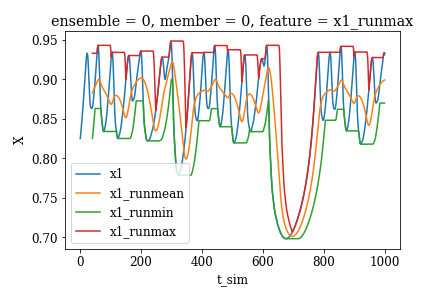

In [17]:
# Plot the running mean, min, and max of x1
fig,ax = plt.subplots()
h_x1, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1"
)
h_x1_runmean, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1_runmean",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1_runmean"
)
h_x1_runmin, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1_runmin",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1_runmin"
)
h_x1_runmax, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(feature="x1_runmax",ensemble=0,member=0,t_sim=slice(None,1000)), ax=ax, label="x1_runmax"
)
ax.legend(handles=[h_x1,h_x1_runmean,h_x1_runmin,h_x1_runmax])

# Define A and B
Define a parameterized family of A and B, in this case a sequence of thresholds for x1_runmin and x1_runmax over a single time horizon. To vary the time horizon instead, we would have to enlarge the state space above to include information at a sequence of time delays.

In [209]:
tpt_bndy = {"tthresh": [10,200], "x1thresh": [0.7, 2.0]}

In [210]:
abcode = {"A": 0, "B": 1, "D": 2}
def abtest(Xtpt, tpt_bndy):
    # Given a snapshot of an instance of the feat_tpt data structure, return ab_tag: 
    # 0 means in A, 1 means in B, and 2 means neither.
    # The definition of A and B will be parameterized by a dictionary, tpt_bndy, which specifies
    # the time of season when blockings can happen as well as the thresholds for A and B. 
    time_window_flag = 1.0*(
        Xtpt.sel(feature="t_szn") >= tpt_bndy["tthresh"][0])*(
        Xtpt.sel(feature="t_szn") <= tpt_bndy["tthresh"][1]
    )
    blocked_flag = 1.0*(Xtpt.sel(feature="x1_runmax") <= tpt_bndy["x1thresh"][0])
    zonal_flag = 1.0*(Xtpt.sel(feature="x1") >= tpt_bndy["x1thresh"][1])
    ab_tag = (
        abcode["A"]*((1*(time_window_flag == 0) + 1*zonal_flag) > 0) + 
        abcode["B"]*(time_window_flag*blocked_flag) + 
        abcode["D"]*(time_window_flag*(blocked_flag==0)*(zonal_flag==0))
    )
    return ab_tag

In [211]:
ab_tag = dict()
for src in ["ra","hc"]:
    ab_tag[src] = abtest(feat_tpt[src]["X"], tpt_bndy)

## Plot x1 over time, marked by whether in A, B, or neither

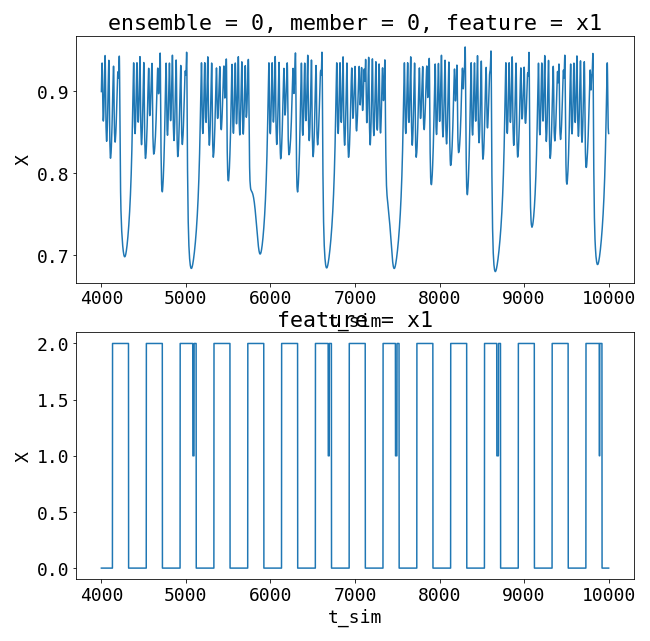

In [212]:
fig,ax = plt.subplots(nrows=2,figsize=(10,10))
selection = {"t_sim": slice(4000,10000), "ensemble": 0, "member": 0}
xr.plot.plot(
    feat_tpt["ra"]["X"].sel(selection).sel(feature="x1"),
    ax=ax[0]
)
xr.plot.plot(
    ab_tag["ra"].sel(selection,drop=True), ax=ax[1]
)


# Find and plot the committor, lead time, and current from reanalysis

In [139]:
# Function to find the time since and until hitting A and B
def cotton_eye_joe(Xtpt, tpt_bndy, ab_tag):
    sintil = xr.DataArray(
        coords = dict({
            "ensemble": Xtpt.coords["ensemble"],
            "member": Xtpt.coords["member"],
            "t_sim": Xtpt.coords["t_sim"],
            "sense": ["since","until"],
            "state": ["A","B"]
        }),
        data = np.nan*np.ones((Xtpt["ensemble"].size, Xtpt["member"].size, Xtpt["t_sim"].size, 2, 2)),
        dims = ["ensemble","member","t_sim","sense","state"],
    )
    # Forward pass through time 
    for i_time in np.arange(sintil["t_sim"].size):    
        if i_time % 200 == 0:
            print(f"Forward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:            
            if i_time > 0:
                sintil[dict(t_sim=i_time)].loc[dict(sense="since",state=state)] = (
                    sintil.isel(t_sim=i_time-1).sel(sense="since",state=state).data + 
                    sintil["t_sim"][i_time].data - sintil["t_sim"][i_time-1].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            # Wherever the state is achieved at this time slice, set the time since to zero
            sintil[dict(t_sim=i_time)].loc[dict(sense="since",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="since",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="since",state=state))
            )
    # Backward pass through time
    for i_time in np.arange(sintil["t_sim"].size-1,-1,-1):
        if i_time % 200 == 0:
            print(f"Backward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:
            if i_time < sintil["t_sim"].size-1:
                sintil[dict(t_sim=i_time)].loc[dict(sense="until",state=state)] = (
                    sintil.isel(t_sim=i_time+1).sel(sense="until",state=state).data + 
                    sintil["t_sim"][i_time+1].data - sintil["t_sim"][i_time].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            sintil[dict(t_sim=i_time)].loc[dict(sense="until",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="until",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="until",state=state))
            )
    return sintil   

In [139]:
# Function to find the time since and until hitting A and B
def cotton_eye_joe_timechunks(Xtpt, tpt_bndy, ab_tag):
    sintil = xr.DataArray(
        coords = dict({
            "ensemble": Xtpt.coords["ensemble"],
            "member": Xtpt.coords["member"],
            "t_sim": Xtpt.coords["t_sim"],
            "sense": ["since","until"],
            "state": ["A","B"]
        }),
        data = np.nan*np.ones((Xtpt["ensemble"].size, Xtpt["member"].size, Xtpt["t_sim"].size, 2, 2)),
        dims = ["ensemble","member","t_sim","sense","state"],
    )
    Nt = Xtpt["t_sim"].size
    # Forward pass through time 
    for ensemble in Xtpt.coords["ensemble"]:
        for member in Xtpt.coords["member"]:
            for state in ["A","B"]:
                indicator = (ab_tag.sel(ensemble=ensemble,member=member,sense="since",state=state) == abcode[state]).data
                # Find the crossover points
                idx_exit = np.where(np.diff(indicator) == -1)[0] + 1 # First step outside of state
                idx_entry = np.where(np.diff(indicator) == 1)[0] + 1 # First entry to state
                # Sweep forward in time to find "time since"
                idx_exit_fwd = idx_exit.copy()
                idx_entry_fwd = idx_entry.copy()
                if idx_entry[0] < idx_exit[0]:
                    idx_entry_fwd = idx_entry_fwd[1:]
                if idx_entry[-1] < idx_exit[-1]:
                    idx_entry_fwd = np.concatenate((idx_entry_fwd,[Nt]))
                tsince = np.nan*np.ones(Nt)
                for k in range(len(idx_exit)):
                    i0,i1 = idx_exit_fwd[k],idx_entry_fwd[k]
                    tsince[i0:i1] = (
                        Xtpt["t_sim"].data[i0:i1] - 
                        Xtpt["t_sim"].data[i0-1]
                    )
                # Sweep backward in time to find "time until"
                
                
                    
                    
        
    for i_time in np.arange(sintil["t_sim"].size):    
        if i_time % 200 == 0:
            print(f"Forward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:            
            if i_time > 0:
                sintil[dict(t_sim=i_time)].loc[dict(sense="since",state=state)] = (
                    sintil.isel(t_sim=i_time-1).sel(sense="since",state=state).data + 
                    sintil["t_sim"][i_time].data - sintil["t_sim"][i_time-1].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            # Wherever the state is achieved at this time slice, set the time since to zero
            sintil[dict(t_sim=i_time)].loc[dict(sense="since",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="since",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="since",state=state))
            )
    # Backward pass through time
    for i_time in np.arange(sintil["t_sim"].size-1,-1,-1):
        if i_time % 200 == 0:
            print(f"Backward pass: through time {i_time} out of {sintil['t_sim'].size}")
        for state in ["A","B"]:
            if i_time < sintil["t_sim"].size-1:
                sintil[dict(t_sim=i_time)].loc[dict(sense="until",state=state)] = (
                    sintil.isel(t_sim=i_time+1).sel(sense="until",state=state).data + 
                    sintil["t_sim"][i_time+1].data - sintil["t_sim"][i_time].data
                )
            state_flag = (ab_tag.isel(t_sim=i_time) == abcode[state])
            sintil[dict(t_sim=i_time)].loc[dict(sense="until",state=state)] = (
                (xr.zeros_like(sintil.isel(t_sim=i_time).sel(sense="until",state=state))).where(
                state_flag, sintil.isel(t_sim=i_time).sel(sense="until",state=state))
            )
    return sintil   

In [140]:
sintil = dict()
for src in ["hc","ra"]:
    sintil[src] = cotton_eye_joe(feat_tpt[src]["X"],tpt_bndy,ab_tag[src])

Forward pass: through time 0 out of 94
Backward pass: through time 0 out of 94
Forward pass: through time 0 out of 56000
Forward pass: through time 200 out of 56000
Forward pass: through time 400 out of 56000
Forward pass: through time 600 out of 56000
Forward pass: through time 800 out of 56000
Forward pass: through time 1000 out of 56000
Forward pass: through time 1200 out of 56000
Forward pass: through time 1400 out of 56000
Forward pass: through time 1600 out of 56000
Forward pass: through time 1800 out of 56000
Forward pass: through time 2000 out of 56000
Forward pass: through time 2200 out of 56000
Forward pass: through time 2400 out of 56000
Forward pass: through time 2600 out of 56000
Forward pass: through time 2800 out of 56000
Forward pass: through time 3000 out of 56000
Forward pass: through time 3200 out of 56000
Forward pass: through time 3400 out of 56000
Forward pass: through time 3600 out of 56000
Forward pass: through time 3800 out of 56000
Forward pass: through time 4

In [119]:
!ls {filedict["results"]["dir"]}

comm_hc.nc  comm_ra.nc	sintil_hc.nc  sintil_ra.nc


Save the sintil object, and then reload it

In [141]:
# Save the sintil objects
for src in ["ra","hc"]:
    sintil[src].to_netcdf(join(filedict["results"]["dir"], f"sintil_{src}.nc"))

In [142]:
sintil = dict()
for src in ["hc","ra"]:
    sintil[src] = xr.open_dataarray(join(filedict["results"]["dir"], f"sintil_{src}.nc"))

In [143]:
# Create a committor object from the sintil object
comm = dict()
for src in ["ra","hc"]:
    comm[src] = 1*(sintil[src].sel(state="B") < sintil[src].sel(state="A"))
    comm[src].loc[dict(sense="since")] = 1 - comm[src].sel(sense="since")
    comm[src].to_netcdf(join(filedict["results"]["dir"], f"comm_{src}.nc"))

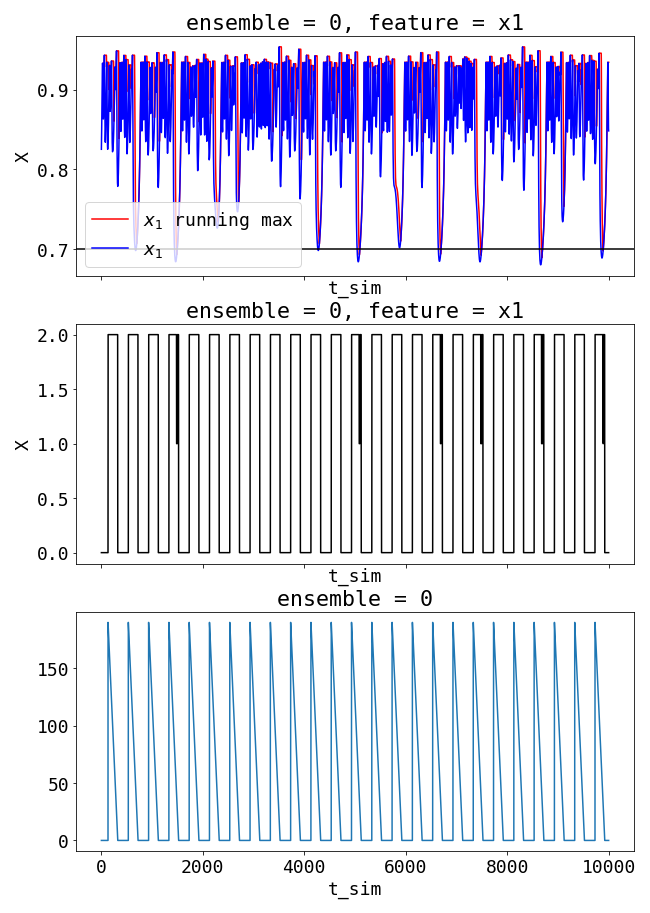

In [213]:
fig,axes = plt.subplots(nrows=3, figsize=(10,15), sharex=True)
sel = dict(member=0, t_sim=slice(None,10000))
h_x1_runmax, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="x1_runmax"),
    color="red",ax=axes[0],label="$x_1$ running max")
h_x1, = xr.plot.plot(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="x1"),
    color="blue",ax=axes[0],label="$x_1$"
)
axes[0].axhline(y=tpt_bndy["x1thresh"][0], color='black')
axes[0].legend(handles=[h_x1_runmax,h_x1])
h_abtag = xr.plot.plot(
    ab_tag["ra"].sel(sel,drop=True),
    color="black", ax=axes[1], label="AB code"
)
h_tbp, = xr.plot.plot(
    sintil["ra"].sel(sel,drop=True).sel(state="A", sense="until", drop=True),
    ax=axes[2], label="$\tau_A^+$")

In [214]:
# Plot the lead time as a function of E01 and E12
reload(helper2)

<module 'helper2' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/helper2.py'>

shapes: field = (56000,), weights = (56000,), features = (56000, 1)
grid_cell: 
min = 
[0]
max=[19]
shapes: field = (56000,), weights = (56000,), features = (56000, 1)
grid_cell: 
min = 
[0]
max=[19]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='t_szn', ylabel='Committor to B'>)

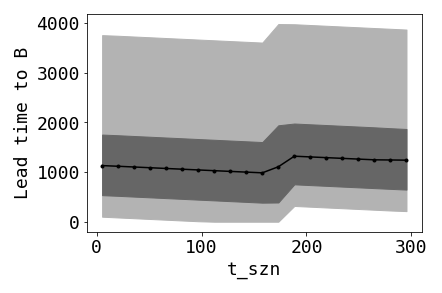

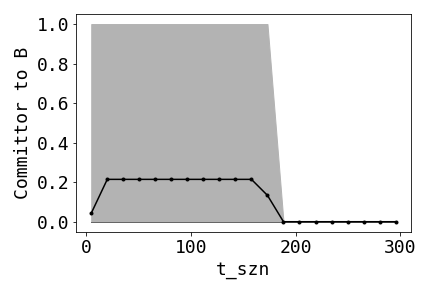

In [216]:
feat = "t_szn"
sel = dict(ensemble=0,member=0)
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > 0) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < 300) 
)
helper2.plot_field_1d(
    sintil["ra"].sel(sel,drop=True).sel(sense="until",state="B").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=[feat]).where(cond).data.flatten(),
    ax=axes[0],
    feat_name=feat, field_name="Lead time to B",
)
helper2.plot_field_1d(
    comm["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten(), 
    np.ones(cond["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=feat).where(cond).data.flatten(),
    ax=axes[1],
    feat_name=feat, field_name="Committor to B"
)

In [147]:
tpt_bndy

{'tthresh': [10, 200], 'x1thresh': [0.7, 2.0]}

shapes: field = (56000,), weights = (56000,), features = (56000, 1)
grid_cell: 
min = 
[0]
max=[19]


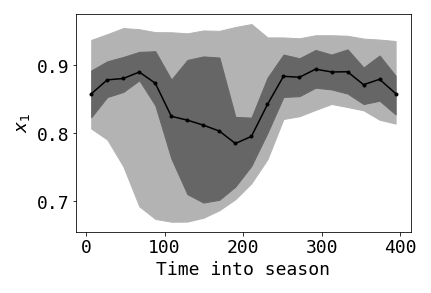

In [148]:
# Plot seasonal statistics of x1
feat = "t_szn"
sel = dict(ensemble=0, member=0)
fig,ax = helper2.plot_field_1d(
    feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="x1").data.flatten(),
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(sel).sel(feature=feat).data.flatten(),
    feat_name="Time into season", field_name="$x_1$"
)

Choose two features for the space to plot

In [183]:
# Plot the lead time as a function of E01 and E12
reload(helper2)

<module 'helper2' from '/home/jf4241/ecmwf/tpt_ecmwf/demo/helper2.py'>

In [184]:
field = comm["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten()
weights = np.ones(feat_tpt["ra"]["t_sim"].size)
features = feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).sel(sel,drop=True)

In [185]:
features

<xarray.DataArray 'X' (t_sim: 56000, feature: 2)>
array([[0.99705106, 0.3404582 ],
       [0.98896286, 0.34174992],
       [0.984219  , 0.34318045],
       ...,
       [1.06925647, 0.35972487],
       [1.05319092, 0.35978647],
       [1.03911772, 0.36002298]])
Coordinates:
  * t_sim    (t_sim) float64 0.0 0.5 1.0 1.5 ... 2.8e+04 2.8e+04 2.8e+04 2.8e+04
  * feature  (feature) <U16 'E_tot' 'E_01'

grid_cell: 
min = 
<xarray.DataArray 'X' (feature: 2)>
array([0, 0])
Coordinates:
  * feature  (feature) <U16 't_szn' 'E_01'
max=<xarray.DataArray 'X' (feature: 2)>
array([29, 29])
Coordinates:
  * feature  (feature) <U16 't_szn' 'E_01'
field_proj shape = (30, 30)


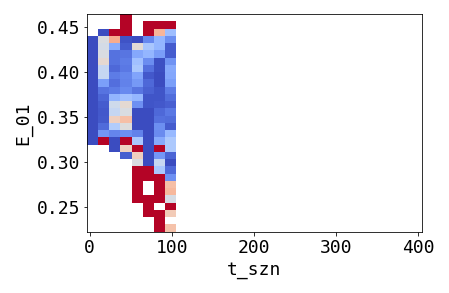

In [219]:
feat0,feat1 = "t_szn","E_01"
sel = dict(ensemble=0,member=0) 
cond = (
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") > 0) * 
    (feat_tpt["ra"]["X"].sel(sel,drop=True).sel(feature="t_szn") < 100) 
)
fig,ax = helper2.plot_field_2d(
    comm["ra"].sel(sel,drop=True).sel(sense="until").where(cond).data.flatten(),
    np.ones(feat_tpt["ra"]["t_sim"].size),
    feat_tpt["ra"]["X"].sel(feature=[feat0,feat1]).sel(sel,drop=True),
    feat_names = [feat0,feat1], 
    shp=[30,30]
)

Text(0, 0.5, 'E_01')

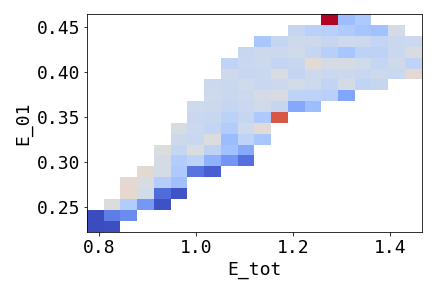

In [150]:
f01,f10 = np.meshgrid(edges[0],edges[1],indexing='ij')
fig,ax = plt.subplots()
ax.pcolormesh(f01,f10,mfpt_proj["mean"],cmap=plt.cm.coolwarm)
ax.set_xlabel(feat0)
ax.set_ylabel(feat1)

In [130]:
np.nanmax(mfpt_proj['mean'])

734.25

In [96]:
idx = np.arange(12).reshape((3,4))
tuple(idx)

(array([0, 1, 2, 3]), array([4, 5, 6, 7]), array([ 8,  9, 10, 11]))

In [83]:
theta = feat_tpt["ra"]["X"].sel(ensemble=0,member=0,feature=["x1","E_12"])

In [87]:
theta.data.shape[1]

2

In [ ]:
data_vars_clim = dict()
t_dim = np.where(np.array(feat_all["hc"].dims) == 't_sim')[0][0]
for obs_name in list(feat_all["hc"].data_vars.keys()):
    shp = list(feat_all["hc"][obs_name].shape)
    shp[t_dim] = crom_feat.Nt_szn
    data_vars_clim[obs_name] = np.zeros(shp)

In [ ]:
for obs_name in list(feat_all["hc"].data_vars.keys()):
    

In [ ]:
feat_all["ra"].data_vars.keys()

In [ ]:
# Load the already-executed model (contiguous)
X_ra_cont = xr.open_dataset(traj_filename_ra)["X"]
print(X_ra_cont.sel(feature="x1").isel(t_sim=0))
print(X_ra_cont.sel(feature="x2").isel(t_sim=0))

In [ ]:
# Plot x1 and x4 over time for 4 annual cycles
fig,ax = plt.subplots(ncols=2, figsize=(12,6))
xr.plot.plot(
    X_ra_cont.sel(feature='x1',member=0)
    .where(X_ra_cont['t_sim'] < 4*crom.q["year_length"], drop=True),
    x='t_sim', ax=ax[0]
)
xr.plot.plot(
    X_ra_cont.sel(feature='x4',member=0)
    .where(X_ra_cont['t_sim'] < 4*crom.q["year_length"], drop=True),
    x='t_sim', ax=ax[1]
)


In [ ]:
# Compute the climatology
feat_crom.compute_climatology(in_filename,save_filename)

In [ ]:
# Plot some hindcasts on top of climatology
